# **1. Perkenalan Dataset**


Tahap pertama, Anda harus mencari dan menggunakan dataset dengan ketentuan sebagai berikut:

1. **Sumber Dataset**:  
   Dataset dapat diperoleh dari berbagai sumber, seperti public repositories (*Kaggle*, *UCI ML Repository*, *Open Data*) atau data primer yang Anda kumpulkan sendiri.


# **2. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning atau deep learning.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# untuk statistik / uji stasioneritas
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

memisahkan import memudahkan reproducibility; statsmodels bantu cek stasioneritas.

# **3. Memuat Dataset**

Pada tahap ini, Anda perlu memuat dataset ke dalam notebook. Jika dataset dalam format CSV, Anda bisa menggunakan pustaka pandas untuk membacanya. Pastikan untuk mengecek beberapa baris awal dataset untuk memahami strukturnya dan memastikan data telah dimuat dengan benar.

Jika dataset berada di Google Drive, pastikan Anda menghubungkan Google Drive ke Colab terlebih dahulu. Setelah dataset berhasil dimuat, langkah berikutnya adalah memeriksa kesesuaian data dan siap untuk dianalisis lebih lanjut.

Jika dataset berupa unstructured data, silakan sesuaikan dengan format seperti kelas Machine Learning Pengembangan atau Machine Learning Terapan

In [ ]:
path = Path('D:\smsml_ratu-chairunisa\raw_dataset\Crypto_Data_Since_2015.csv')
df = pd.read_csv(path)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').set_index('Date')
df.head()

,Bitcoin (USD),Ethereum (USD),Gold (USD per oz),Cardano (ADA),Binance Coin (BNB),Ripple (XRP),Dogecoin (DOGE),Solana (SOL)
Date,,,,,,,,
2015-01-01,1099.671415,102.760097,1199.071870,0.490443,19.915520,0.209481,0.045930,5.987009
2015-01-02,1135.844985,110.806193,1201.928708,0.526877,20.271863,0.222041,0.054818,5.687508
2015-01-03,1250.613839,116.286699,1201.829678,0.520009,19.974075,0.229863,0.049255,7.050012
2015-01-04,1452.916825,118.393314,1199.858272,0.563435,19.942816,0.243224,0.047298,7.903578
2015-01-05,1479.501487,128.322865,1200.014190,0.644235,20.201745,0.238137,0.044584,8.140522


parse tanggal & set index time-series penting untuk operasi resampling / rolling / split waktu.

# **4. Exploratory Data Analysis (EDA)**

Pada tahap ini, Anda akan melakukan **Exploratory Data Analysis (EDA)** untuk memahami karakteristik dataset.

Tujuan dari EDA adalah untuk memperoleh wawasan awal yang mendalam mengenai data dan menentukan langkah selanjutnya dalam analisis atau pemodelan.

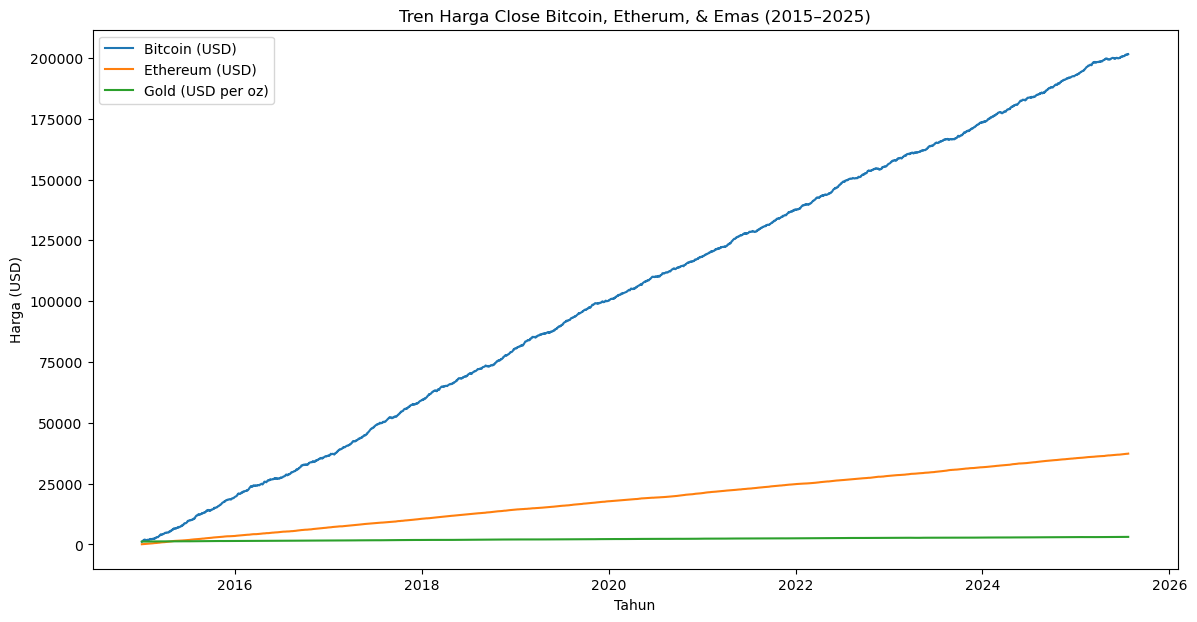

In [3]:
# Visualisasi Tren Harga
plt.figure(figsize=(14, 7))
symbols_to_plot = ["Bitcoin (USD)", "Ethereum (USD)", "Gold (USD per oz)"]
for symbol in symbols_to_plot:
    plt.plot(
        df.index,
        df[symbol],
        label=symbol
    )
plt.title("Tren Harga Close Bitcoin, Etherum, & Emas (2015–2025)")
plt.xlabel("Tahun")
plt.ylabel("Harga (USD)")
plt.legend()
plt.show()

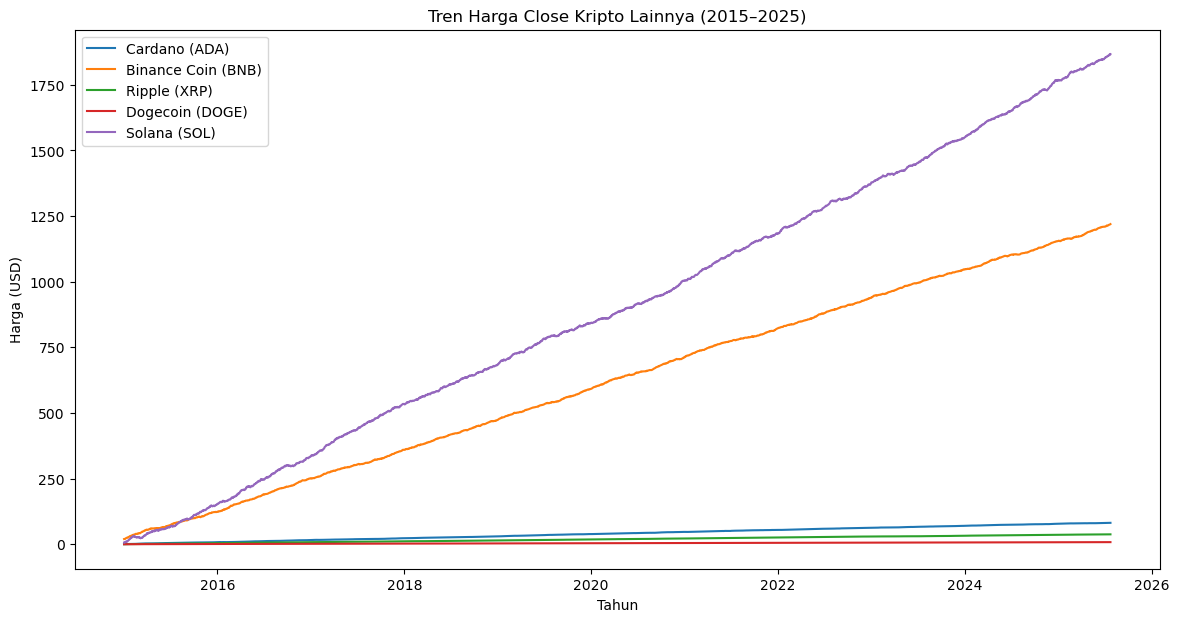

In [4]:
# Visualisasi Tren Harga
plt.figure(figsize=(14, 7))
symbols_to_plot = ["Cardano (ADA)", "Binance Coin (BNB)", "Ripple (XRP)", "Dogecoin (DOGE)", "Solana (SOL)"]
for symbol in symbols_to_plot:
    plt.plot(
        df.index,
        df[symbol],
        label=symbol
    )
plt.title("Tren Harga Close Kripto Lainnya (2015–2025)")
plt.xlabel("Tahun")
plt.ylabel("Harga (USD)")
plt.legend()
plt.show()

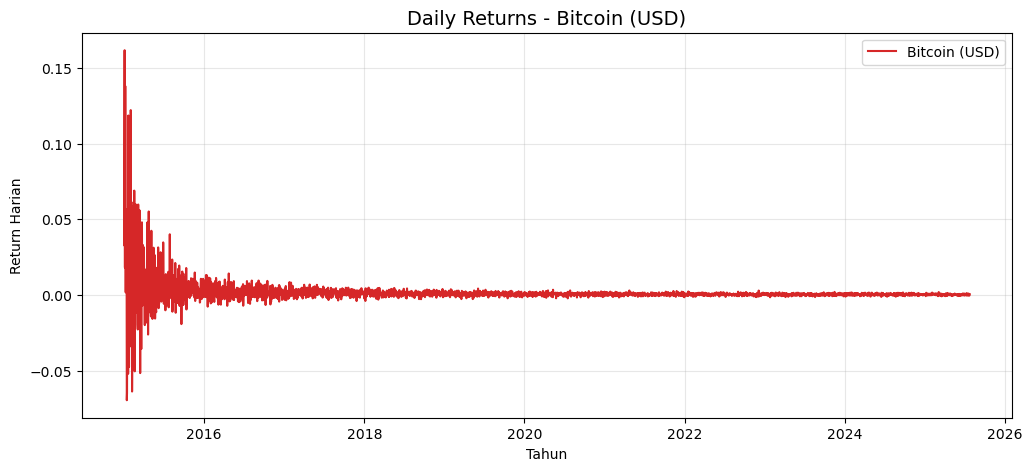

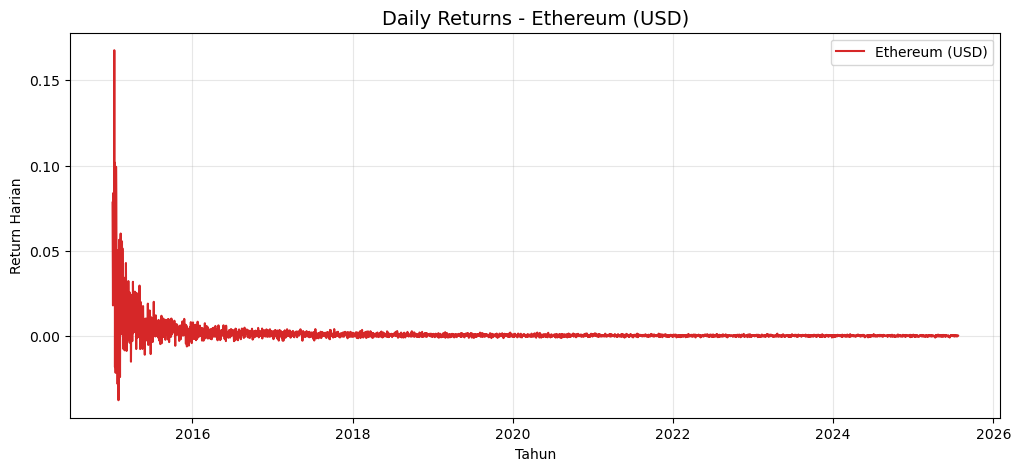

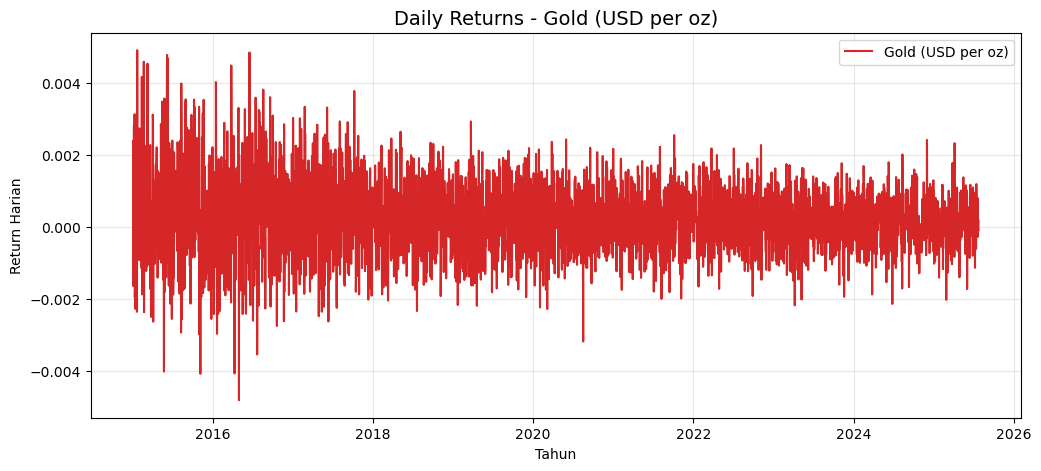

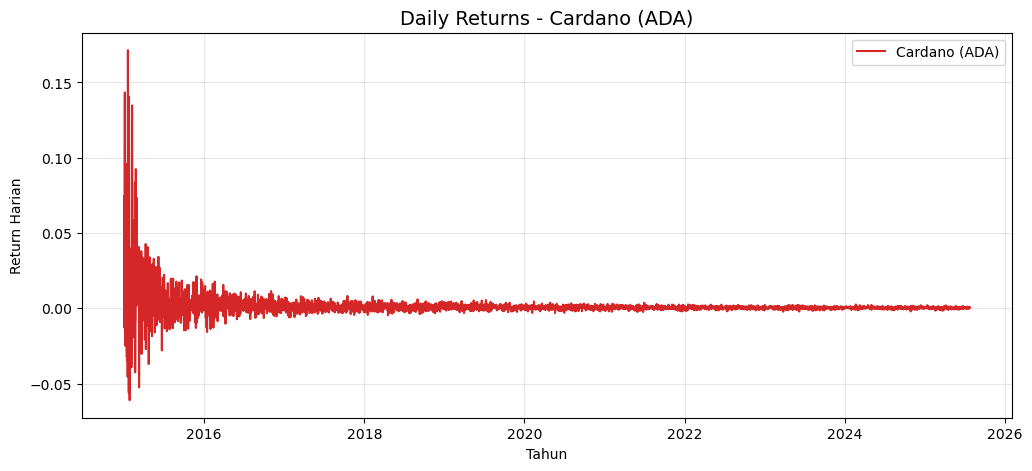

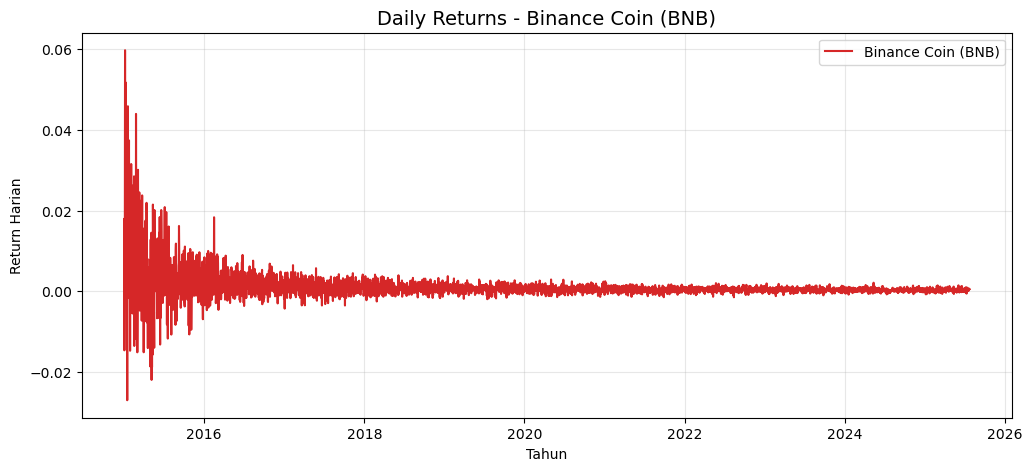

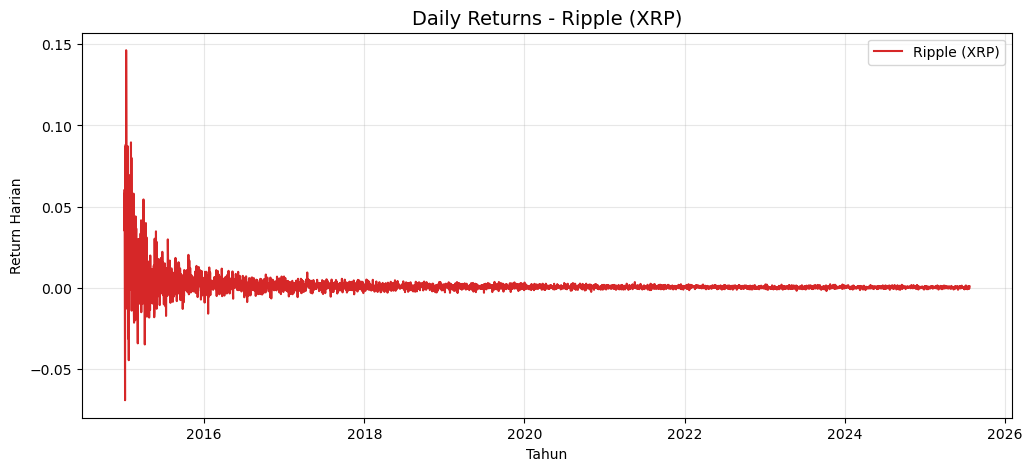

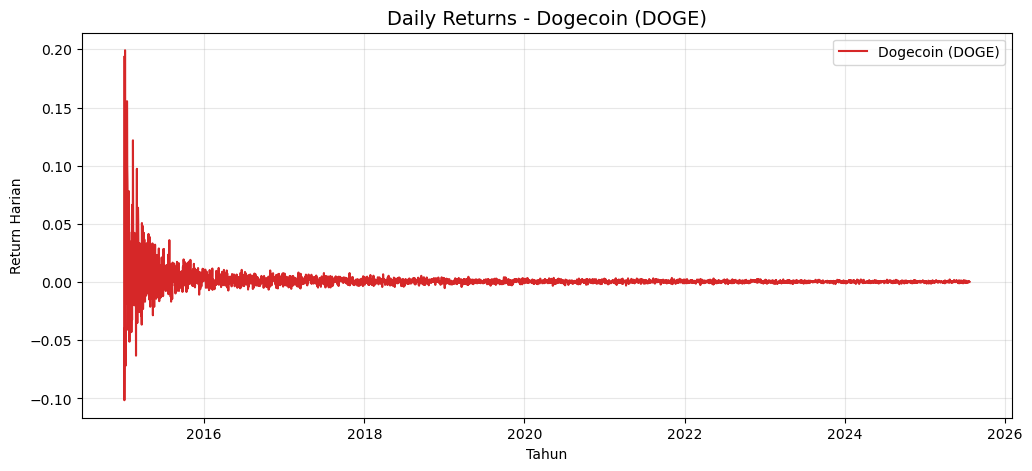

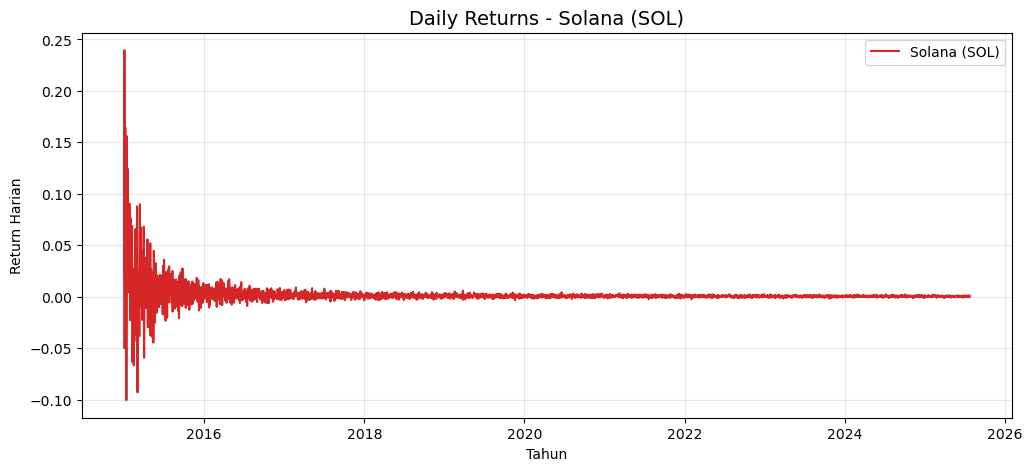

In [5]:
# Calculate daily returns
daily_returns = df.pct_change().dropna()

# Loop to display the daily returns plot for each crypto
for column in daily_returns.columns:
    plt.figure(figsize=(12, 5))
    plt.plot(daily_returns.index, daily_returns[column], label=f"{column}", color="tab:red")

    plt.title(f"Daily Returns - {column}", fontsize=14)
    plt.xlabel("Tahun")
    plt.ylabel("Return Harian")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

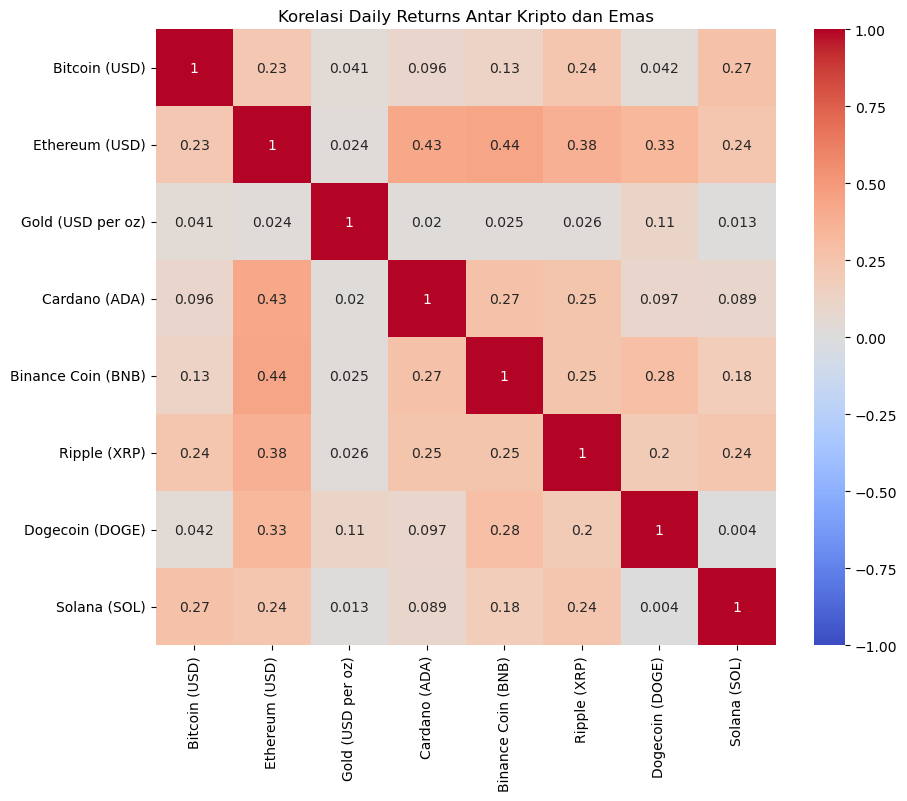

In [6]:
correlation_matrix = daily_returns.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Korelasi Daily Returns Antar Kripto dan Emas")
plt.show()

# **5. Data Preprocessing**

Pada tahap ini, data preprocessing adalah langkah penting untuk memastikan kualitas data sebelum digunakan dalam model machine learning.

Jika Anda menggunakan data teks, data mentah sering kali mengandung nilai kosong, duplikasi, atau rentang nilai yang tidak konsisten, yang dapat memengaruhi kinerja model. Oleh karena itu, proses ini bertujuan untuk membersihkan dan mempersiapkan data agar analisis berjalan optimal.

Berikut adalah tahapan-tahapan yang bisa dilakukan, tetapi **tidak terbatas** pada:
1. Menghapus atau Menangani Data Kosong (Missing Values)
2. Menghapus Data Duplikat
3. Normalisasi atau Standarisasi Fitur
4. Deteksi dan Penanganan Outlier
5. Encoding Data Kategorikal
6. Binning (Pengelompokan Data)

Cukup sesuaikan dengan karakteristik data yang kamu gunakan yah. Khususnya ketika kami menggunakan data tidak terstruktur.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3858 entries, 2015-01-01 to 2025-07-24
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Bitcoin (USD)       3858 non-null   float64
 1   Ethereum (USD)      3858 non-null   float64
 2   Gold (USD per oz)   3858 non-null   float64
 3   Cardano (ADA)       3858 non-null   float64
 4   Binance Coin (BNB)  3858 non-null   float64
 5   Ripple (XRP)        3858 non-null   float64
 6   Dogecoin (DOGE)     3858 non-null   float64
 7   Solana (SOL)        3858 non-null   float64
dtypes: float64(8)
memory usage: 271.3 KB


In [8]:
# Melihat missing value
df.isnull().sum()

Bitcoin (USD)         0
Ethereum (USD)        0
Gold (USD per oz)     0
Cardano (ADA)         0
Binance Coin (BNB)    0
Ripple (XRP)          0
Dogecoin (DOGE)       0
Solana (SOL)          0
dtype: int64

In [9]:
# Melihat data duplikat
print("Jumlah data duplikat:", df.duplicated().sum())

Jumlah data duplikat: 0


In [10]:
df.describe()

,Bitcoin (USD),Ethereum (USD),Gold (USD per oz),Cardano (ADA),Binance Coin (BNB),Ripple (XRP),Dogecoin (DOGE),Solana (SOL)
count,3858.000000,3858.000000,3858.000000,3858.000000,3858.000000,3858.000000,3858.000000,3858.000000
mean,103295.091119,18646.484019,2219.843587,41.150393,623.130826,19.308745,3.931897,906.933311
std,59086.885281,10770.200525,540.896499,23.796932,348.628727,10.848451,2.257275,532.415463
min,1099.671415,102.760097,1199.071870,0.490443,19.915520,0.209481,0.044584,5.687508
25%,51775.591274,9183.157088,1766.802440,20.141836,313.600483,9.928481,2.004034,468.198474
50%,105376.860438,18646.902925,2256.204837,40.974391,631.888911,19.377614,3.767681,884.089973
75%,154587.897710,27888.634698,2697.102069,62.185396,928.463897,29.273697,5.929516,1361.069455
max,201506.238999,37333.366859,3119.461819,81.532909,1219.517885,37.667654,7.971408,1866.601974


In [11]:
# Uji stasioneritas
def adf_test(series):
    r = adfuller(series.dropna())
    return dict(stat=r[0], pvalue=r[1])

# Apply the adf_test function to each column of the daily_returns DataFrame
adf_results = {col: adf_test(daily_returns[col]) for col in daily_returns.columns}
print("ADF Test Results (Daily Returns):")
for col, result in adf_results.items():
    print(f"{col}: ADF Statistic={result['stat']:.4f}, P-value={result['pvalue']:.4f}")

ADF Test Results (Daily Returns):
Bitcoin (USD): ADF Statistic=-5.1084, P-value=0.0000
Ethereum (USD): ADF Statistic=-17.1830, P-value=0.0000
Gold (USD per oz): ADF Statistic=-12.5742, P-value=0.0000
Cardano (ADA): ADF Statistic=-5.8421, P-value=0.0000
Binance Coin (BNB): ADF Statistic=-9.3318, P-value=0.0000
Ripple (XRP): ADF Statistic=-11.5472, P-value=0.0000
Dogecoin (DOGE): ADF Statistic=-16.3676, P-value=0.0000
Solana (SOL): ADF Statistic=-17.5536, P-value=0.0000


walaupun LSTM tidak memerlukan stasioneritas, mengetahui apakah seri stasioner membantu memutuskan differencing/log transform.

In [12]:
# Missing dates and re-index
idx = pd.date_range(df.index.min(), df.index.max(), freq='D')
df = df.reindex(idx)
df = df.ffill()   # atau interpolasi

LSTM mengharapkan sequence berurutan; filler mencegah lubang pada windowing

In [13]:
# Memilih fitur
selected_columns = ["Bitcoin (USD)", "Ethereum (USD)", "Gold (USD per oz)", "Cardano (ADA)", "Binance Coin (BNB)", "Ripple (XRP)", "Dogecoin (DOGE)", "Solana (SOL)"]
N_FEATURES = len(selected_columns)
print("jumlah fitur yang digunakan:", N_FEATURES)

jumlah fitur yang digunakan: 8


In [14]:
# Ambil hanya kolom yang dipilih
df_values = df[selected_columns].values
n_total = len(df_values)

In [15]:
# Train/Val/Test Split berdasarkan Waktu (tanpa shuffle)
train_size = int(n_total * 0.7)
val_size = int(n_total * 0.15)

train_raw = df_values[:train_size]
val_raw   = df_values[train_size:train_size + val_size]
test_raw  = df_values[train_size + val_size:]

print("Train raw shape:", train_raw.shape)
print("Val raw shape  :", val_raw.shape)
print("Test raw shape :", test_raw.shape)

Train raw shape: (2700, 8)
Val raw shape  : (578, 8)
Test raw shape : (580, 8)


In [16]:
# Scaling (fit hanya di train, transform ke val & test)
scaler = MinMaxScaler()

train_scaled = scaler.fit_transform(train_raw)
val_scaled   = scaler.transform(val_raw)
test_scaled  = scaler.transform(test_raw)

In [17]:
# fungsi untuk membuat windowing (sequence input-output)
def create_sequences(data, n_past, n_future, stride=1):
    X, y = [], []
    n_total = len(data)
    for start in range(0, n_total - n_past - n_future + 1, stride):
        end_past = start + n_past
        end_future = end_past + n_future
        X.append(data[start:end_past, :])   # input window
        y.append(data[end_past:end_future, :])  # target window
    return np.array(X), np.array(y)

In [18]:
# Buat window untuk masing-masing split
n_past = 30   # 30 hari ke belakang
n_future = 30 # prediksi 30 hari ke depan
stride = 1

X_train, y_train = create_sequences(train_scaled, n_past, n_future, stride)
X_val, y_val     = create_sequences(val_scaled, n_past, n_future, stride)
X_test, y_test   = create_sequences(test_scaled, n_past, n_future, stride)

print("Train set:", X_train.shape, y_train.shape)
print("Val set  :", X_val.shape, y_val.shape)
print("Test set :", X_test.shape, y_test.shape)

Train set: (2641, 30, 8) (2641, 30, 8)
Val set  : (519, 30, 8) (519, 30, 8)
Test set : (521, 30, 8) (521, 30, 8)


1. selected_columns + N_FEATURES → kita hanya ambil fitur yang relevan (8 aset). N_FEATURES dipakai untuk tahu berapa dimensi input per timestep.

2. create_sequences → inti windowing:
  - Potong data menjadi window input sepanjang n_past timesteps.
  - Targetnya adalah window masa depan sepanjang n_future timesteps.
  - stride mengatur seberapa jauh jendela digeser tiap kali.

3. Split Train/Val/Test berdasarkan waktu:
  - Karena ini time series, kita tidak boleh shuffle data (akan merusak urutan waktu).
  - Split dilakukan secara berurutan: data awal → train, tengah → val, akhir → test.

4. Pemeriksaan Shape:
  - X.shape = (n_windows, n_past, n_features) → banyak window, panjang tiap window, jumlah fitur.
  - y.shape = (n_windows, n_future, n_features) → banyak window, panjang horizon prediksi, jumlah fitur.

Returns:
  - X : numpy.ndarray -- Input sequences dengan shape (n_windows, n_past, n_features).
  - y : numpy.ndarray -- Target sequences dengan shape (n_windows, n_future, n_features).

# Modelling

In [31]:
def build_model(n_past, n_features, n_future):
    model = Sequential([
        LSTM(64, activation="tanh", return_sequences=True, input_shape=(n_past, n_features)),
        Dropout(0.2),
        LSTM(32, activation="tanh"),
        Dense(n_future * n_features)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss="mse", metrics=["mae", "mse"])
    return model

In [29]:
# Early stopping (monitor val_loss)
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

In [32]:
# Training model
model = build_model(n_past, N_FEATURES, n_future)
history = model.fit(
    X_train, y_train.reshape(len(y_train), -1),
    validation_data=(X_val, y_val.reshape(len(y_val), -1)),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50


c:\Users\62852\anaconda3\envs\smsml_queen\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0748 - mae: 0.1584 - mse: 0.0748 - val_loss: 0.0173 - val_mae: 0.1125 - val_mse: 0.0173
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.3761e-04 - mae: 0.0198 - mse: 6.3761e-04 - val_loss: 0.0112 - val_mae: 0.0912 - val_mse: 0.0112
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.2658e-04 - mae: 0.0163 - mse: 4.2658e-04 - val_loss: 0.0113 - val_mae: 0.0936 - val_mse: 0.0113
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.4461e-04 - mae: 0.0146 - mse: 3.4461e-04 - val_loss: 0.0106 - val_mae: 0.0909 - val_mse: 0.0106
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.0243e-04 - mae: 0.0136 - mse: 3.0243e-04 - val_loss: 0.0092 - val_mae: 0.0833 - val_mse: 0.0092
Epoch 6/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.5406e-04 - mae: 0.0124 - mse: 2.5406e-04 - val_loss: 0.0075 - val_mae: 0.0725 - val_mse: 0.0075
Epoch 7/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.5697e-04 - mae: 

In [26]:
# Evaluasi pada test set
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_true = y_test.reshape(len(y_test), -1)

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)

    print("MAE:", mae)
    print("MSE:", mse)
    return mae, mse

print("\nEvaluasi Model:")
mae, mse = evaluate_model(model, X_test, y_test)


Evaluasi Model:
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
MAE: 0.25006695566754783
MSE: 0.06678947138835639


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


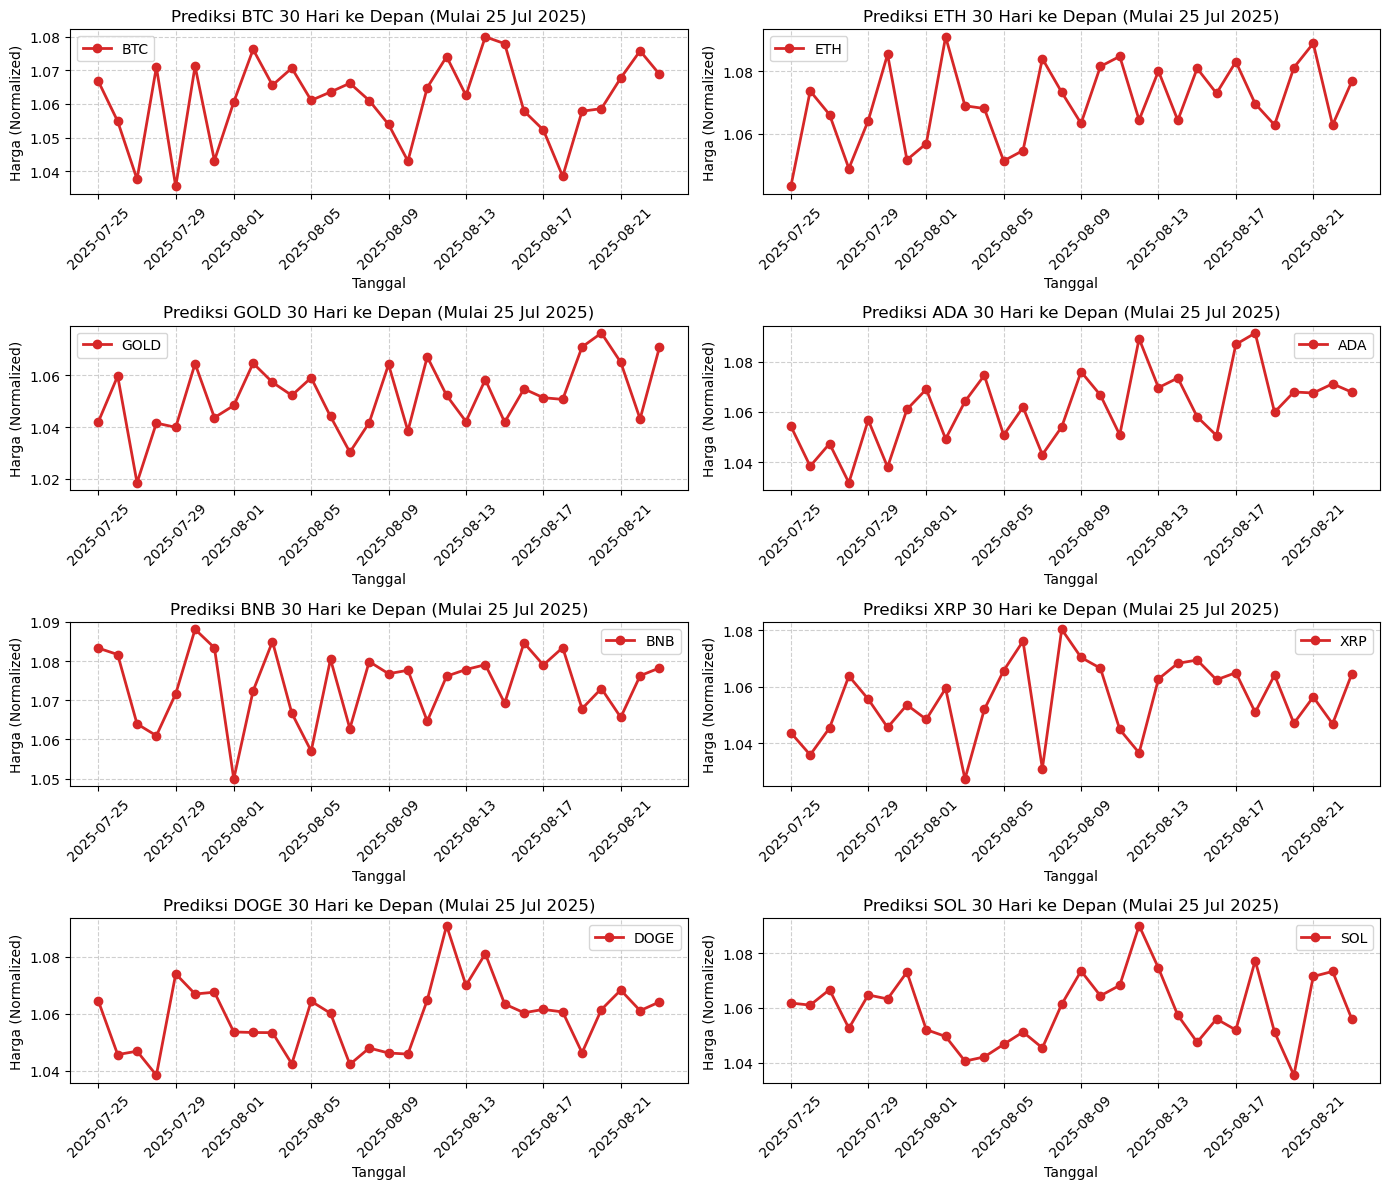

In [27]:
# Ambil 1 contoh prediksi dari X_test
y_pred = model.predict(X_test)  #
predictions = y_pred[0].reshape(n_future, N_FEATURES)  # reshape ke (n_future, n_features)

# Nama crypto sesuai selected_columns
crypto_names = ["BTC", "ETH", "GOLD", "ADA", "BNB", "XRP", "DOGE", "SOL"]

# Data tanggal: mulai dari hari setelah data terakhir
last_date = pd.to_datetime("2025-07-24")  # sesuaikan dengan data asli
future_dates = pd.date_range(
    start=last_date + pd.Timedelta(days=1),
    periods=n_future,
    freq="D"
)

# Visualisasi subplot untuk semua crypto
n_crypto = len(crypto_names)
n_cols = 2
n_rows = int(np.ceil(n_crypto / n_cols))

plt.figure(figsize=(14, 3 * n_rows))

for i, crypto in enumerate(crypto_names):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.plot(future_dates, predictions[:, i], marker="o", linewidth=2,
             label=crypto, color="tab:red")
    plt.title(f"Prediksi {crypto} {n_future} Hari ke Depan (Mulai {last_date + pd.Timedelta(days=1):%d %b %Y})")
    plt.xlabel("Tanggal")
    plt.ylabel("Harga (Normalized)")
    plt.xticks(rotation=45)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()

plt.tight_layout()
plt.show()